# CVAE

Original dataset shape: (766, 91)
Number of classes: 4
names of classes: ['B' 'PreB' 'PreT' 'T']


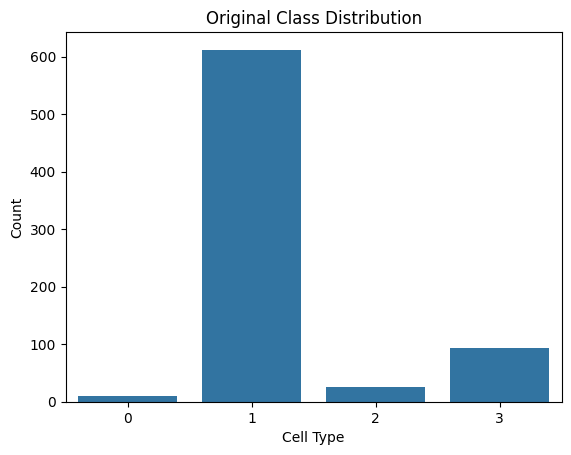

In [22]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# === Load and preprocess dataset ===
df = pd.read_csv('input/ML_data.csv')
print(f"Original dataset shape: {df.shape}")

# Drop sample ID column
df = df.drop(columns=['Samples'])

# Filter out unwanted cell types
df = df[~df['Cell_type'].isin(['Unknown'])]

# Encode 'Cell_type' labels
le = LabelEncoder()
df['Cell_type'] = le.fit_transform(df['Cell_type'])
label_names = le.classes_
n_classes = len(label_names)
print(f"Number of classes: {n_classes}")
print(f"names of classes: {label_names}")


# Normalize gene expression features
feature_columns = df.columns[df.columns != 'Cell_type']
scaler = MinMaxScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Split features and labels
X = df[feature_columns].values.astype(np.float32)
y = df['Cell_type'].values
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)
y_onehot = torch.nn.functional.one_hot(y_tensor, num_classes=n_classes).float()

# DataLoader
dataset = TensorDataset(X_tensor, y_onehot)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualize class distribution
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Cell Type")
plt.ylabel("Count")
plt.show()



In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ----------------------
# Encoder: maps (X + label) → latent space (mu, logvar)
# ----------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + label_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)  # Concatenate input and label
        h = self.net(xy)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# ----------------------
# Decoder: maps (z + label) → reconstructed X
# ----------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + label_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, z, y):
        zy = torch.cat([z, y], dim=1)  # Concatenate latent vector and label
        return self.net(zy)


# ----------------------
# CVAE: the full model that links encoder + decoder
# ----------------------
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim=8, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, label_dim, latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, label_dim, input_dim, hidden_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std  # Reparameterization trick

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, y)
        return x_recon, mu, logvar


# ----------------------
# Loss function = MSE + KL Divergence
# ----------------------
def loss_function(x_recon, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld, recon_loss, kld


# ----------------------
# Train the CVAE model
# ----------------------
def train_cvae(model, dataloader, optimizer, epochs, X_full, y_full, label_names, latent_dim, device):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x_batch, y_batch)
            beta = min(1.0, epoch / 500)
            loss, recon_loss, kld = loss_function(x_recon, x_batch, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Epoch {epoch}] β={beta:.2f} | Recon: {recon_loss.item():.4f} | KL: {kld.item():.4f} | Total: {loss.item():.4f}")

        # Optional: visualize real vs synthetic data
        if epoch % 250 == 0 or epoch == epochs:
            for class_id in range(len(label_names)):
                label_tensor = torch.tensor([class_id] * 1000)
                label_onehot = F.one_hot(label_tensor, num_classes=len(label_names)).float()
                synthetic_samples = sample_cvae(model, 1000, label_onehot, latent_dim, device)
                real_samples = X_full[y_full == class_id]
                fig, ax = plt.subplots(figsize=(8, 6))
                final_pca_plot(real_samples, synthetic_samples, class_id, label_names, ax)
                plt.show()


# ----------------------
# Sample new synthetic data from decoder
# ----------------------
def sample_cvae(model, num_samples, label_tensor, latent_dim, device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        y = label_tensor.to(device)
        samples = model.decoder(z, y)
    return samples.cpu().numpy()


# ----------------------
# PCA plot to visualize real vs synthetic data
# ----------------------
def final_pca_plot(real_X, synthetic_X, synthetic_label, label_names, ax):
    X_combined = np.vstack([real_X, synthetic_X])
    labels_combined = np.array(['Real'] * len(real_X) + ['Synthetic'] * len(synthetic_X))
    X_pca = PCA(n_components=2).fit_transform(X_combined)

    color_map = {'Real': 'orange', 'Synthetic': 'blue'}
    for label in ['Real', 'Synthetic']:
        idx = labels_combined == label
        ax.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6, color=color_map[label])
    ax.set_title(f"PCA - Real vs Synthetic ({label_names[synthetic_label]})")
    ax.legend()


# ----------------------
# Generate full DataFrame of synthetic samples
# ----------------------
def generate_synthetic_df(model, class_id, n_samples, label_names, feature_columns, latent_dim, device):
    model.eval()
    synthetic_dfs = []

    if class_id == 'all':
        for cid in range(len(label_names)):
            label_tensor = torch.tensor([cid] * n_samples)
            label_onehot = torch.nn.functional.one_hot(label_tensor, num_classes=len(label_names)).float().to(device)
            with torch.no_grad():
                z = torch.randn(n_samples, latent_dim).to(device)
                synthetic_data = model.decoder(z, label_onehot).cpu().numpy()
            df = pd.DataFrame(synthetic_data, columns=feature_columns)
            df['Cell_type'] = label_names[cid]
            synthetic_dfs.append(df)
        synthetic_df = pd.concat(synthetic_dfs, ignore_index=True)
    else:
        label_tensor = torch.tensor([class_id] * n_samples)
        label_onehot = torch.nn.functional.one_hot(label_tensor, num_classes=len(label_names)).float().to(device)
        with torch.no_grad():
            z = torch.randn(n_samples, latent_dim).to(device)
            synthetic_data = model.decoder(z, label_onehot).cpu().numpy()
        synthetic_df = pd.DataFrame(synthetic_data, columns=feature_columns)
        synthetic_df['Cell_type'] = label_names[class_id]

    return synthetic_df


## Optuna

In [ ]:
import optuna
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA

# ---------------------
# PCA distance metric
# ---------------------
def pca_distance(real, fake, n_components=10):
    pca = PCA(n_components=n_components)
    real_pca = pca.fit_transform(real)
    fake_pca = pca.transform(fake)
    return np.linalg.norm(real_pca.mean(axis=0) - fake_pca.mean(axis=0))

# ---------------------
# Optuna tuning objective
# ---------------------
def objective(trial):
    # --- Suggest hyperparameters ---
    latent_dim = trial.suggest_int("latent_dim", 8, 64)
    hidden_dim = trial.suggest_int("hidden_dim", 64, 512, step=64)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    # --- Prepare DataLoader ---
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), 
                            torch.tensor(y_onehot, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- Model, Optimizer ---
    model = CVAE(input_dim=X.shape[1], label_dim=n_classes,
                 latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # --- Train for small number of epochs (for tuning only) ---
    model.train()
    for epoch in range(150):  # Keep it short for tuning
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(xb, yb)
            loss = loss_function(x_recon, xb, mu, logvar)
            loss.backward()
            optimizer.step()

    # --- Evaluate using PCA distance for a minority class (e.g. label 2) ---
    model.eval()
    label_eval = 2
    n_eval = 300
    with torch.no_grad():
        y_eval_tensor = F.one_hot(torch.tensor([label_eval] * n_eval),
                                  num_classes=n_classes).float().to(device)
        z = torch.randn(n_eval, latent_dim).to(device)
        X_fake = model.decoder(z, y_eval_tensor).cpu().numpy()

    X_real = X[y == label_eval]
    dist = pca_distance(X_real, X_fake)
    return dist  # Lower is better

# ---------------------
# Setup & Launch Optuna Study
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# You must define the following from your dataset:
# X              --> shape (samples, features)
# y              --> shape (samples,) with integer labels
# y_onehot       --> one-hot encoded version of y
# label_names    --> list of class names
# n_classes      --> number of classes
# feature_columns --> list of gene/feature names

study = optuna.create_study(direction="minimize", study_name="CVAE RNA-seq tuning")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:")
print(study.best_params)
best_params = study.best_params

# Save Optuna results
df_trials = study.trials_dataframe()
df_trials.to_csv("optuna_cvae_results.csv", index=False)



[I 2025-04-30 18:04:49,049] A new study created in memory with name: CVAE RNA-seq tuning
/tmp/ipykernel_863806/1406442328.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_onehot, dtype=torch.float32))
[W 2025-04-30 18:04:49,070] Trial 0 failed with parameters: {'latent_dim': 62, 'hidden_dim': 448, 'lr': 0.00108357721549602, 'batch_size': 32} because of the following error: AttributeError("'tuple' object has no attribute 'backward'").
Traceback (most recent call last):
  File "/home/thomas/miniconda3/envs/DeepN/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_863806/1406442328.py", line 36, in objective
    loss.backward()
    ^^^^^^^^^^^^^
AttributeError: 'tuple' object has no attribute 'backward'

AttributeError: 'tuple' object has no attribute 'backward'

## Loop

[Epoch 1] β=0.00 | Recon: 0.1118 | KL: 0.6178 | Total: 0.1131
[Epoch 2] β=0.00 | Recon: 0.0715 | KL: 1.1541 | Total: 0.0761
[Epoch 3] β=0.01 | Recon: 0.0622 | KL: 1.2638 | Total: 0.0698
[Epoch 4] β=0.01 | Recon: 0.0554 | KL: 0.8461 | Total: 0.0622
[Epoch 5] β=0.01 | Recon: 0.0553 | KL: 0.5086 | Total: 0.0604
[Epoch 6] β=0.01 | Recon: 0.0497 | KL: 0.4378 | Total: 0.0550
[Epoch 7] β=0.01 | Recon: 0.0488 | KL: 0.3255 | Total: 0.0534
[Epoch 8] β=0.02 | Recon: 0.0470 | KL: 0.3078 | Total: 0.0519
[Epoch 9] β=0.02 | Recon: 0.0483 | KL: 0.2180 | Total: 0.0522
[Epoch 10] β=0.02 | Recon: 0.0444 | KL: 0.2244 | Total: 0.0488
[Epoch 11] β=0.02 | Recon: 0.0442 | KL: 0.1712 | Total: 0.0480
[Epoch 12] β=0.02 | Recon: 0.0407 | KL: 0.1838 | Total: 0.0452
[Epoch 13] β=0.03 | Recon: 0.0414 | KL: 0.1856 | Total: 0.0462
[Epoch 14] β=0.03 | Recon: 0.0409 | KL: 0.1436 | Total: 0.0449
[Epoch 15] β=0.03 | Recon: 0.0390 | KL: 0.1285 | Total: 0.0429
[Epoch 16] β=0.03 | Recon: 0.0363 | KL: 0.1257 | Total: 0.0404
[

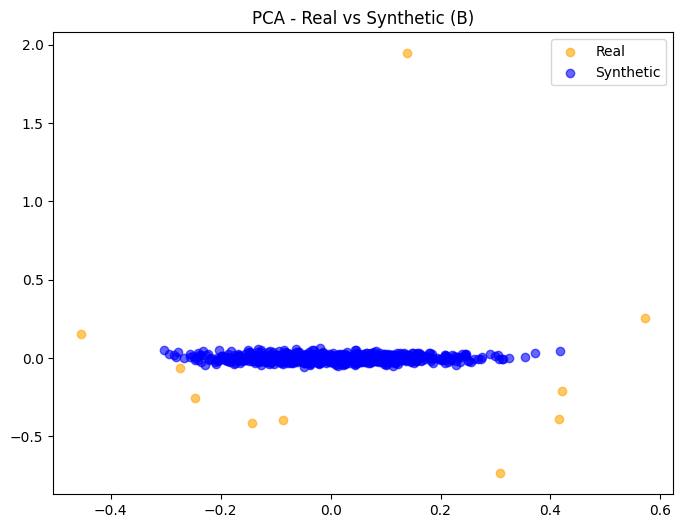

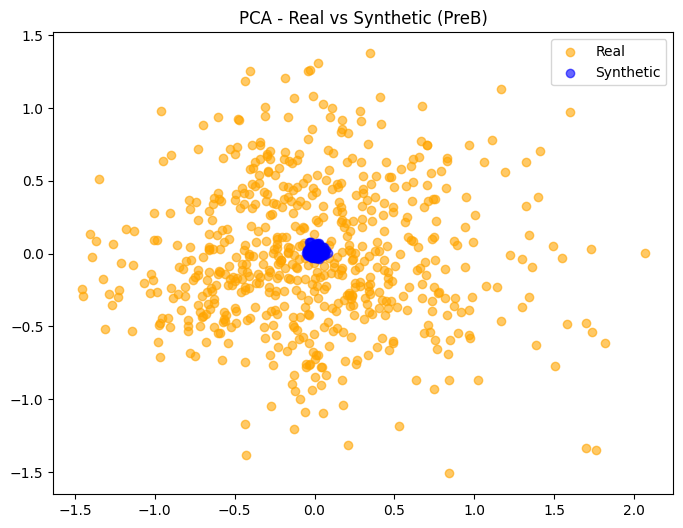

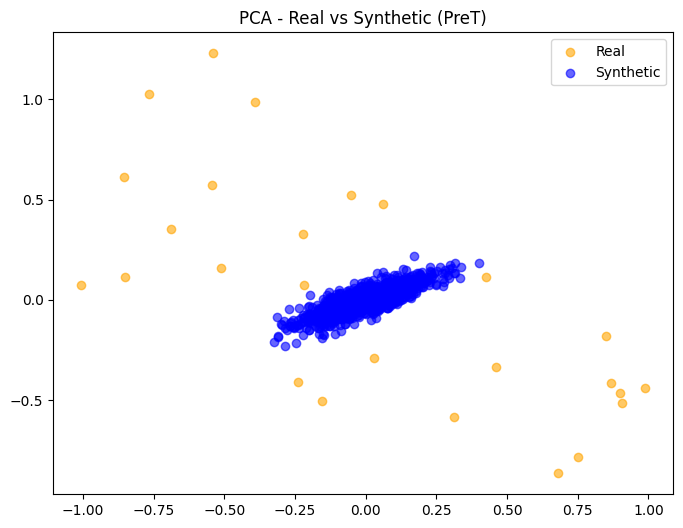

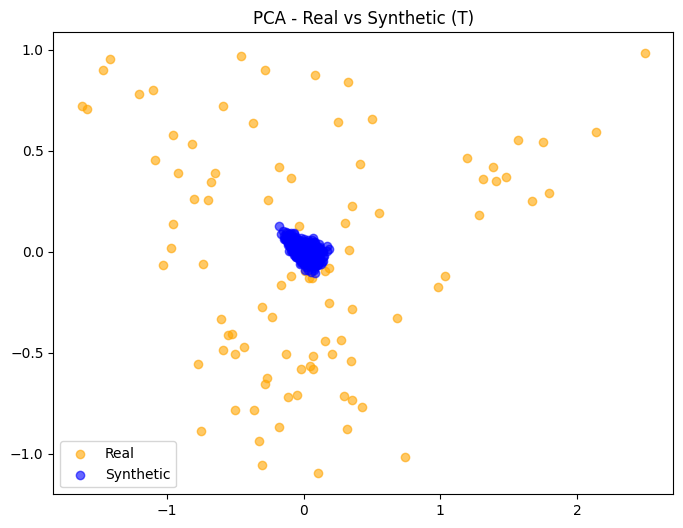

[Epoch 251] β=0.50 | Recon: 0.0300 | KL: 0.0000 | Total: 0.0300
[Epoch 252] β=0.50 | Recon: 0.0323 | KL: 0.0000 | Total: 0.0323
[Epoch 253] β=0.51 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 254] β=0.51 | Recon: 0.0321 | KL: 0.0000 | Total: 0.0321
[Epoch 255] β=0.51 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 256] β=0.51 | Recon: 0.0318 | KL: 0.0000 | Total: 0.0318
[Epoch 257] β=0.51 | Recon: 0.0319 | KL: 0.0000 | Total: 0.0320
[Epoch 258] β=0.52 | Recon: 0.0313 | KL: 0.0000 | Total: 0.0313
[Epoch 259] β=0.52 | Recon: 0.0313 | KL: 0.0000 | Total: 0.0313
[Epoch 260] β=0.52 | Recon: 0.0305 | KL: 0.0000 | Total: 0.0305
[Epoch 261] β=0.52 | Recon: 0.0304 | KL: 0.0000 | Total: 0.0304
[Epoch 262] β=0.52 | Recon: 0.0313 | KL: 0.0000 | Total: 0.0313
[Epoch 263] β=0.53 | Recon: 0.0317 | KL: 0.0000 | Total: 0.0317
[Epoch 264] β=0.53 | Recon: 0.0309 | KL: 0.0000 | Total: 0.0309
[Epoch 265] β=0.53 | Recon: 0.0309 | KL: 0.0000 | Total: 0.0309
[Epoch 266] β=0.53 | Recon: 0.0325 | KL:

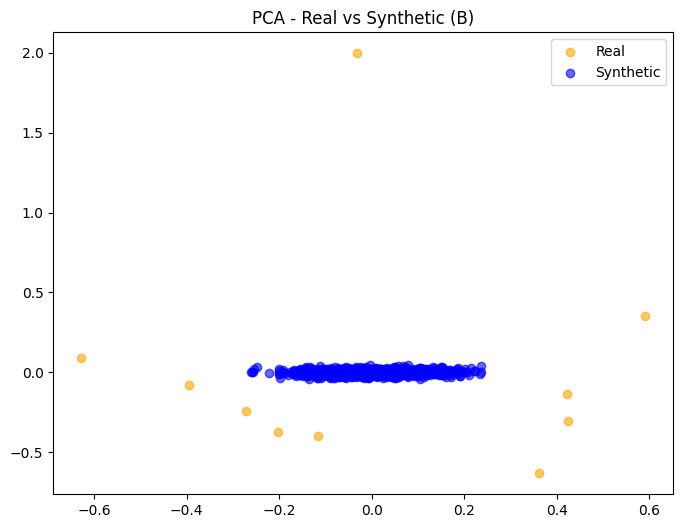

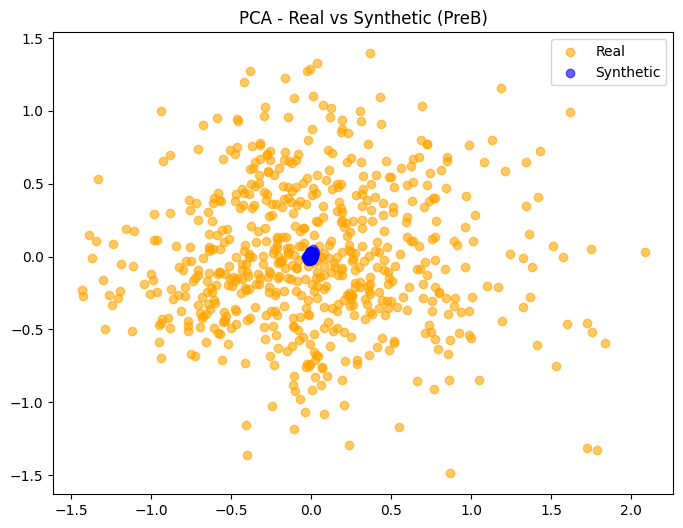

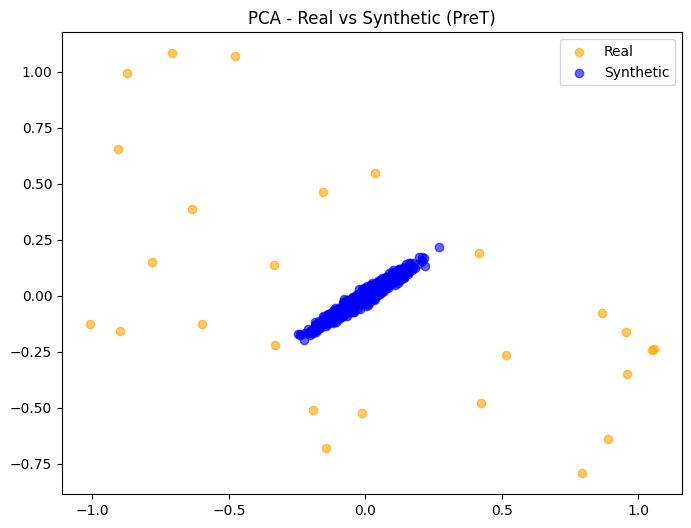

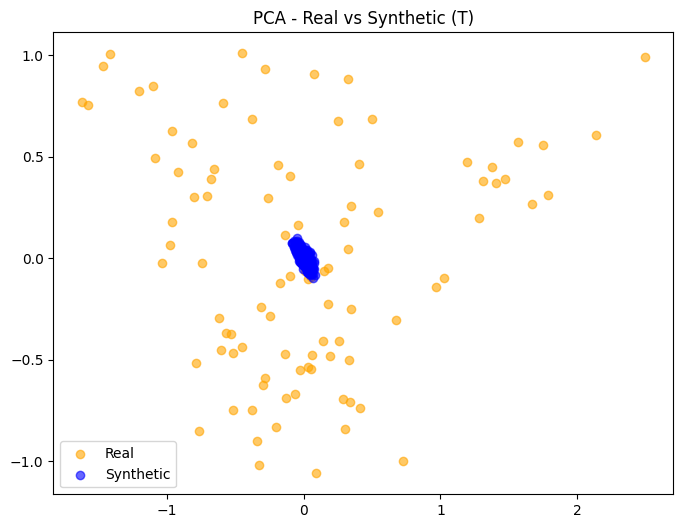

[Epoch 501] β=1.00 | Recon: 0.0317 | KL: 0.0000 | Total: 0.0317
[Epoch 502] β=1.00 | Recon: 0.0336 | KL: 0.0000 | Total: 0.0336
[Epoch 503] β=1.00 | Recon: 0.0290 | KL: 0.0000 | Total: 0.0290
[Epoch 504] β=1.00 | Recon: 0.0328 | KL: 0.0000 | Total: 0.0328
[Epoch 505] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 506] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 507] β=1.00 | Recon: 0.0307 | KL: 0.0000 | Total: 0.0307
[Epoch 508] β=1.00 | Recon: 0.0330 | KL: 0.0000 | Total: 0.0330
[Epoch 509] β=1.00 | Recon: 0.0291 | KL: 0.0000 | Total: 0.0291
[Epoch 510] β=1.00 | Recon: 0.0313 | KL: 0.0000 | Total: 0.0313
[Epoch 511] β=1.00 | Recon: 0.0305 | KL: 0.0000 | Total: 0.0305
[Epoch 512] β=1.00 | Recon: 0.0300 | KL: 0.0000 | Total: 0.0300
[Epoch 513] β=1.00 | Recon: 0.0295 | KL: 0.0000 | Total: 0.0296
[Epoch 514] β=1.00 | Recon: 0.0312 | KL: 0.0000 | Total: 0.0312
[Epoch 515] β=1.00 | Recon: 0.0324 | KL: 0.0000 | Total: 0.0324
[Epoch 516] β=1.00 | Recon: 0.0326 | KL:

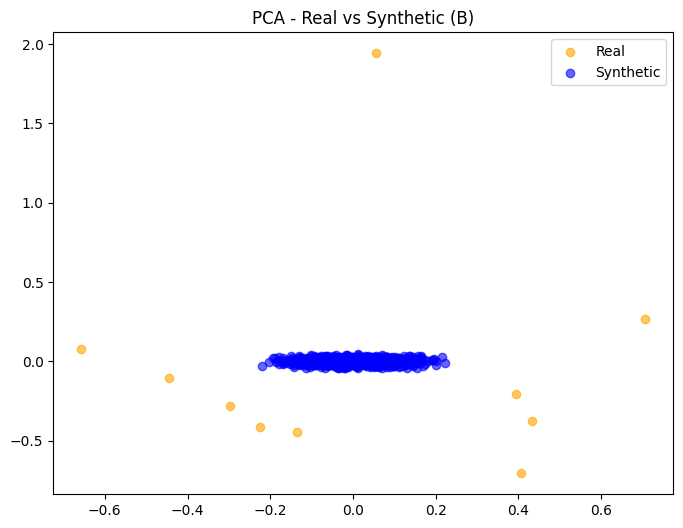

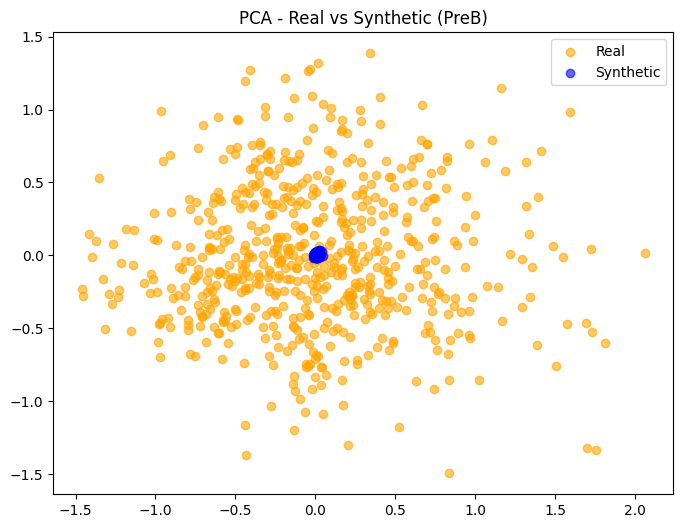

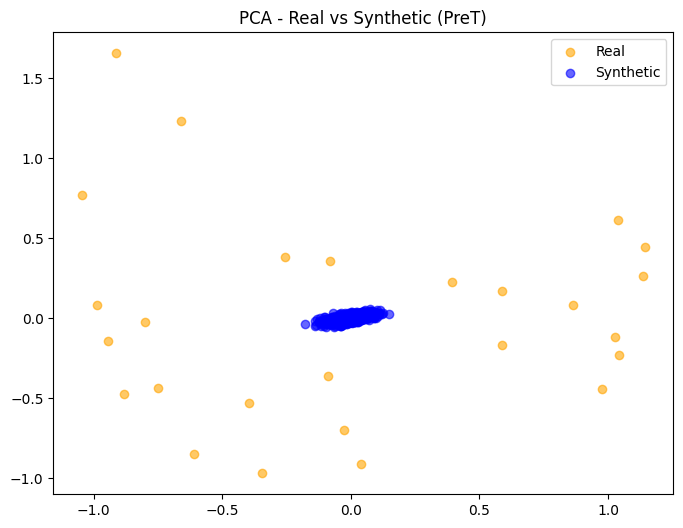

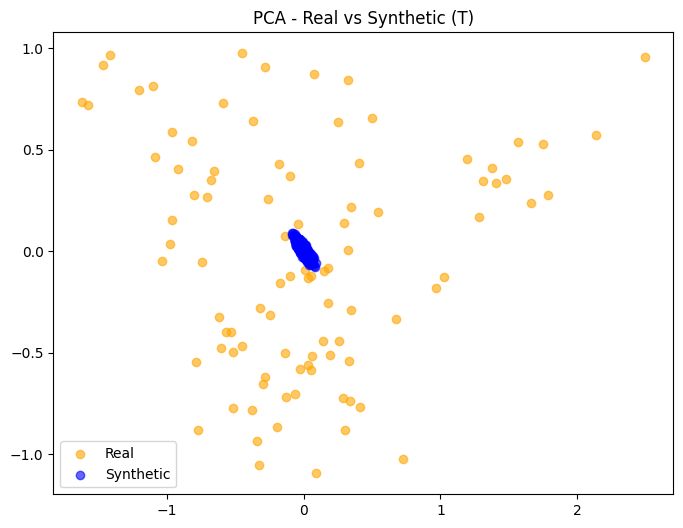

[Epoch 751] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 752] β=1.00 | Recon: 0.0282 | KL: 0.0000 | Total: 0.0282
[Epoch 753] β=1.00 | Recon: 0.0323 | KL: 0.0000 | Total: 0.0323
[Epoch 754] β=1.00 | Recon: 0.0311 | KL: 0.0000 | Total: 0.0311
[Epoch 755] β=1.00 | Recon: 0.0314 | KL: 0.0000 | Total: 0.0314
[Epoch 756] β=1.00 | Recon: 0.0323 | KL: 0.0000 | Total: 0.0323
[Epoch 757] β=1.00 | Recon: 0.0331 | KL: 0.0000 | Total: 0.0331
[Epoch 758] β=1.00 | Recon: 0.0326 | KL: 0.0000 | Total: 0.0326
[Epoch 759] β=1.00 | Recon: 0.0316 | KL: 0.0000 | Total: 0.0316
[Epoch 760] β=1.00 | Recon: 0.0313 | KL: 0.0000 | Total: 0.0313
[Epoch 761] β=1.00 | Recon: 0.0320 | KL: 0.0000 | Total: 0.0320
[Epoch 762] β=1.00 | Recon: 0.0321 | KL: 0.0000 | Total: 0.0321
[Epoch 763] β=1.00 | Recon: 0.0314 | KL: 0.0000 | Total: 0.0314
[Epoch 764] β=1.00 | Recon: 0.0318 | KL: 0.0000 | Total: 0.0318
[Epoch 765] β=1.00 | Recon: 0.0312 | KL: 0.0000 | Total: 0.0312
[Epoch 766] β=1.00 | Recon: 0.0312 | KL:

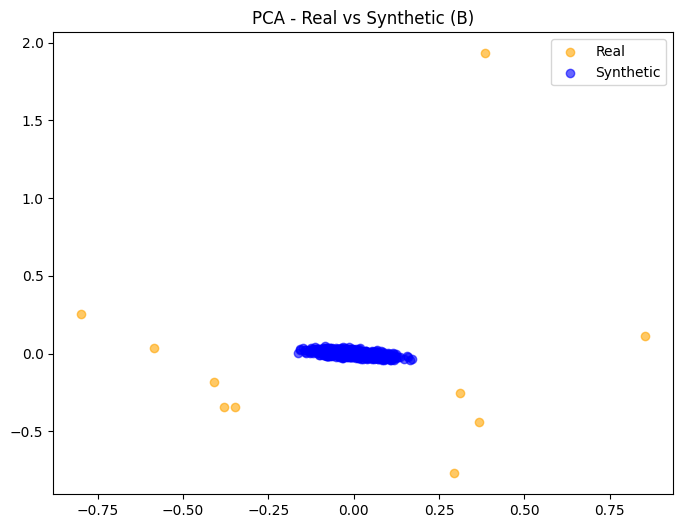

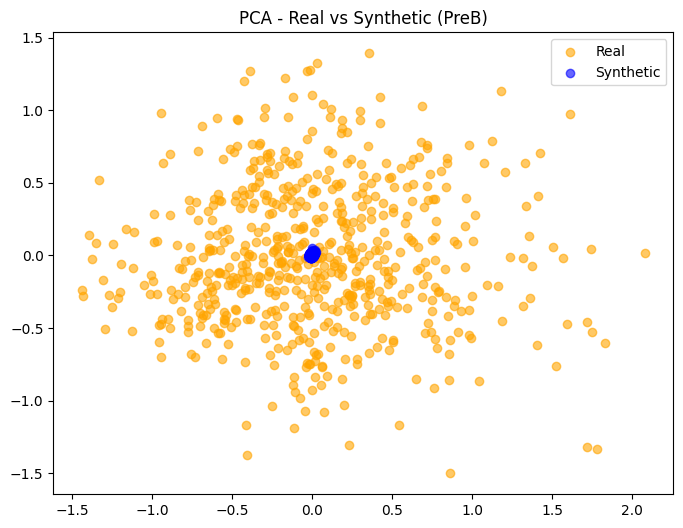

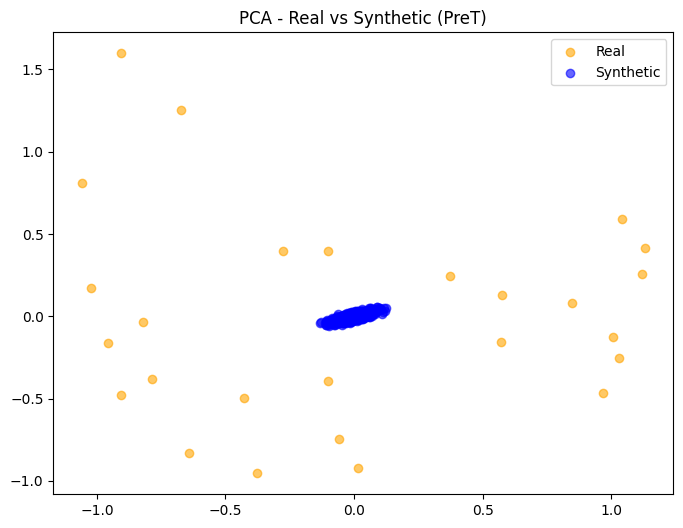

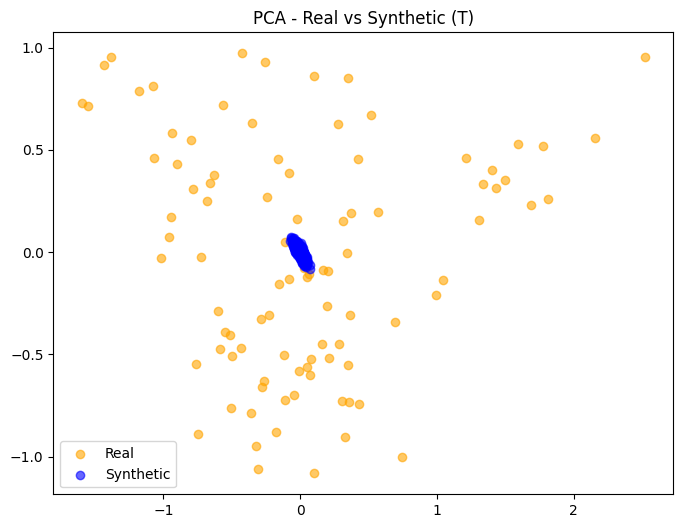

[Epoch 1001] β=1.00 | Recon: 0.0307 | KL: 0.0000 | Total: 0.0307
[Epoch 1002] β=1.00 | Recon: 0.0307 | KL: 0.0000 | Total: 0.0307
[Epoch 1003] β=1.00 | Recon: 0.0309 | KL: 0.0000 | Total: 0.0309
[Epoch 1004] β=1.00 | Recon: 0.0289 | KL: 0.0000 | Total: 0.0289
[Epoch 1005] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 1006] β=1.00 | Recon: 0.0320 | KL: 0.0000 | Total: 0.0320
[Epoch 1007] β=1.00 | Recon: 0.0329 | KL: 0.0000 | Total: 0.0329
[Epoch 1008] β=1.00 | Recon: 0.0294 | KL: 0.0000 | Total: 0.0294
[Epoch 1009] β=1.00 | Recon: 0.0314 | KL: 0.0000 | Total: 0.0314
[Epoch 1010] β=1.00 | Recon: 0.0324 | KL: 0.0000 | Total: 0.0324
[Epoch 1011] β=1.00 | Recon: 0.0307 | KL: 0.0000 | Total: 0.0307
[Epoch 1012] β=1.00 | Recon: 0.0315 | KL: 0.0000 | Total: 0.0315
[Epoch 1013] β=1.00 | Recon: 0.0312 | KL: 0.0000 | Total: 0.0312
[Epoch 1014] β=1.00 | Recon: 0.0319 | KL: 0.0000 | Total: 0.0319
[Epoch 1015] β=1.00 | Recon: 0.0295 | KL: 0.0000 | Total: 0.0295
[Epoch 1016] β=1.00 | Rec

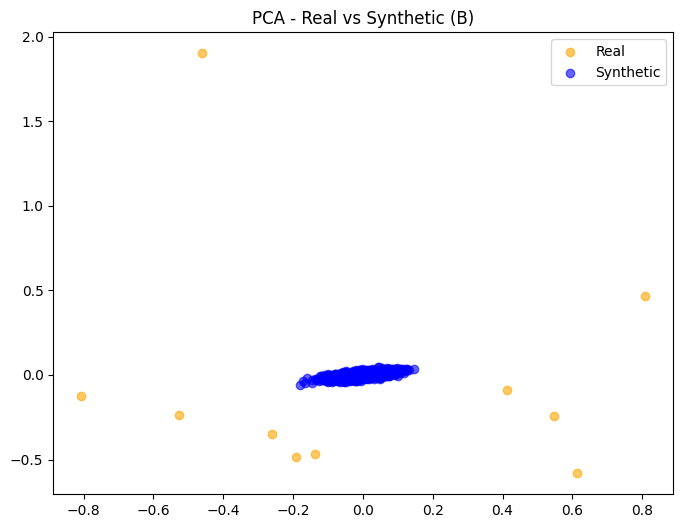

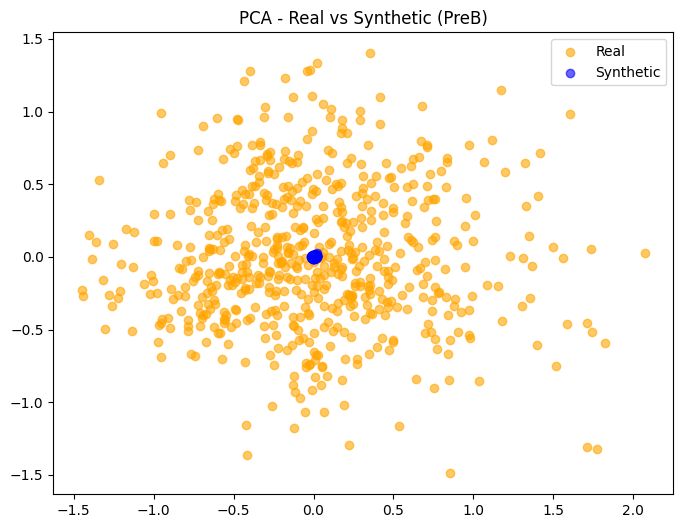

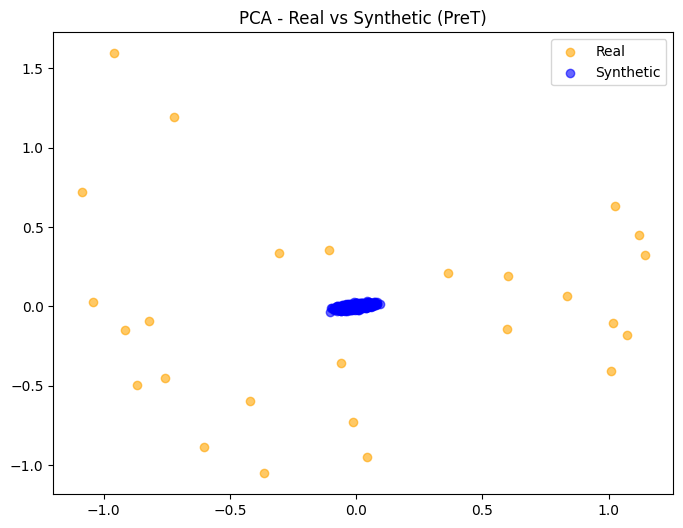

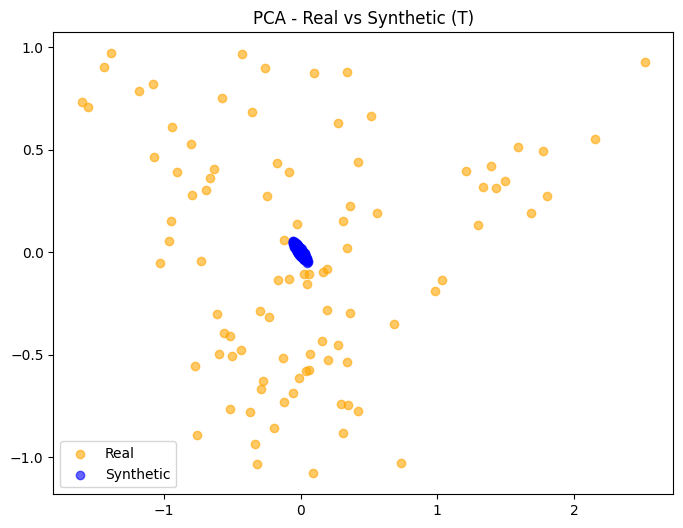

[Epoch 1251] β=1.00 | Recon: 0.0319 | KL: 0.0000 | Total: 0.0319
[Epoch 1252] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 1253] β=1.00 | Recon: 0.0317 | KL: 0.0000 | Total: 0.0317
[Epoch 1254] β=1.00 | Recon: 0.0311 | KL: 0.0000 | Total: 0.0311
[Epoch 1255] β=1.00 | Recon: 0.0285 | KL: 0.0000 | Total: 0.0285
[Epoch 1256] β=1.00 | Recon: 0.0293 | KL: 0.0000 | Total: 0.0293
[Epoch 1257] β=1.00 | Recon: 0.0322 | KL: 0.0000 | Total: 0.0322
[Epoch 1258] β=1.00 | Recon: 0.0307 | KL: 0.0000 | Total: 0.0307
[Epoch 1259] β=1.00 | Recon: 0.0304 | KL: 0.0000 | Total: 0.0304
[Epoch 1260] β=1.00 | Recon: 0.0308 | KL: 0.0000 | Total: 0.0308
[Epoch 1261] β=1.00 | Recon: 0.0309 | KL: 0.0000 | Total: 0.0309
[Epoch 1262] β=1.00 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 1263] β=1.00 | Recon: 0.0310 | KL: 0.0000 | Total: 0.0310
[Epoch 1264] β=1.00 | Recon: 0.0312 | KL: 0.0000 | Total: 0.0312
[Epoch 1265] β=1.00 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 1266] β=1.00 | Rec

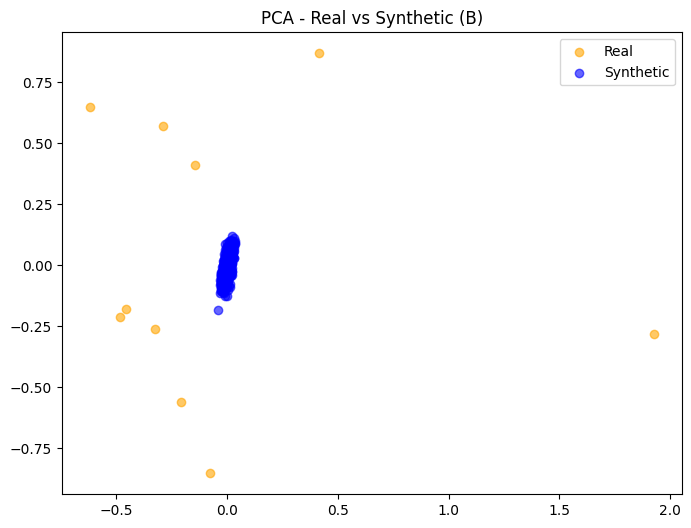

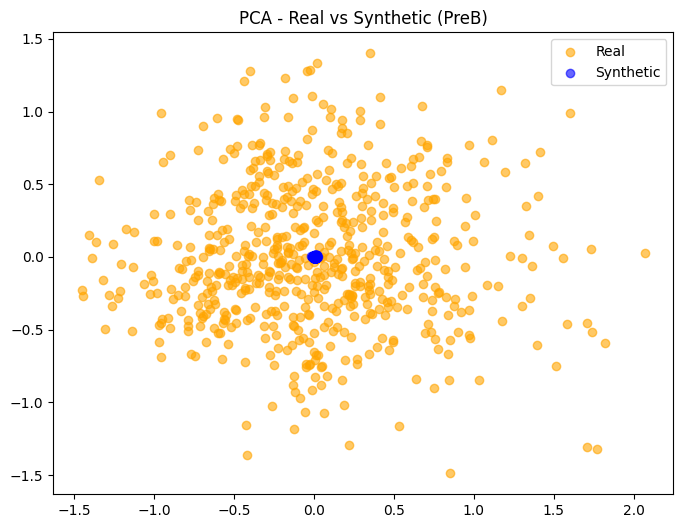

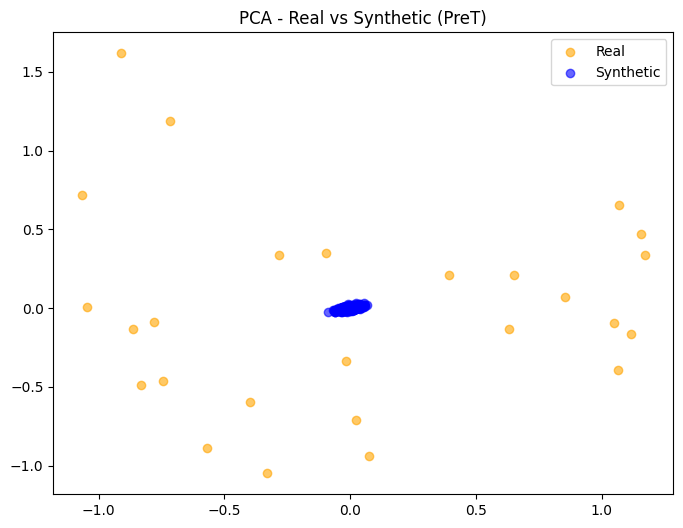

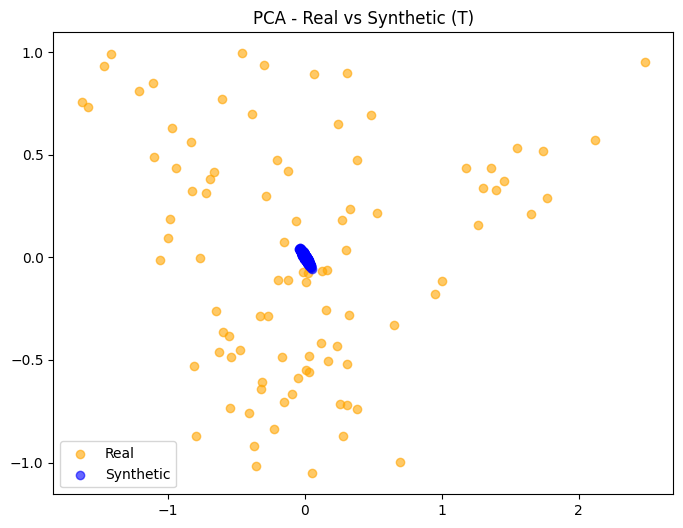

[Epoch 1501] β=1.00 | Recon: 0.0302 | KL: 0.0000 | Total: 0.0302
[Epoch 1502] β=1.00 | Recon: 0.0318 | KL: 0.0000 | Total: 0.0318
[Epoch 1503] β=1.00 | Recon: 0.0305 | KL: 0.0000 | Total: 0.0305
[Epoch 1504] β=1.00 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 1505] β=1.00 | Recon: 0.0302 | KL: 0.0000 | Total: 0.0302
[Epoch 1506] β=1.00 | Recon: 0.0300 | KL: 0.0000 | Total: 0.0300
[Epoch 1507] β=1.00 | Recon: 0.0289 | KL: 0.0000 | Total: 0.0289
[Epoch 1508] β=1.00 | Recon: 0.0288 | KL: 0.0000 | Total: 0.0288
[Epoch 1509] β=1.00 | Recon: 0.0298 | KL: 0.0000 | Total: 0.0298
[Epoch 1510] β=1.00 | Recon: 0.0318 | KL: 0.0000 | Total: 0.0318
[Epoch 1511] β=1.00 | Recon: 0.0324 | KL: 0.0000 | Total: 0.0324
[Epoch 1512] β=1.00 | Recon: 0.0331 | KL: 0.0000 | Total: 0.0331
[Epoch 1513] β=1.00 | Recon: 0.0303 | KL: 0.0000 | Total: 0.0303
[Epoch 1514] β=1.00 | Recon: 0.0326 | KL: 0.0000 | Total: 0.0326
[Epoch 1515] β=1.00 | Recon: 0.0311 | KL: 0.0000 | Total: 0.0311
[Epoch 1516] β=1.00 | Rec

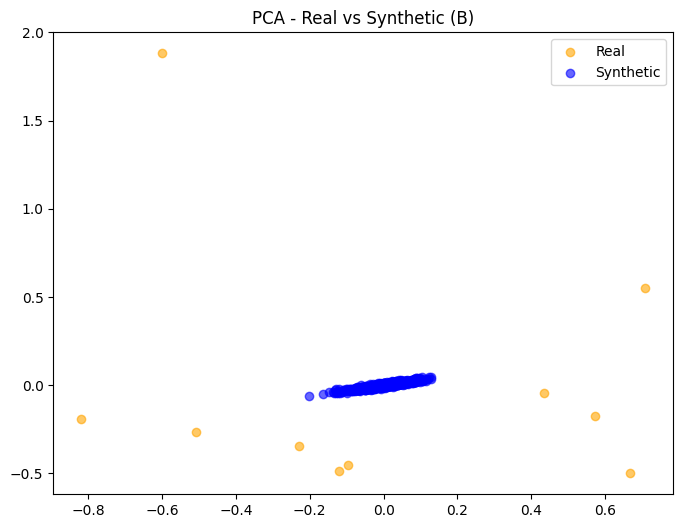

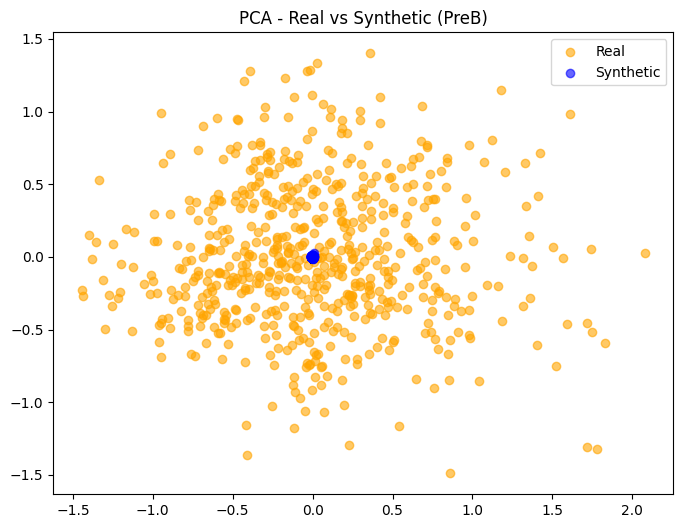

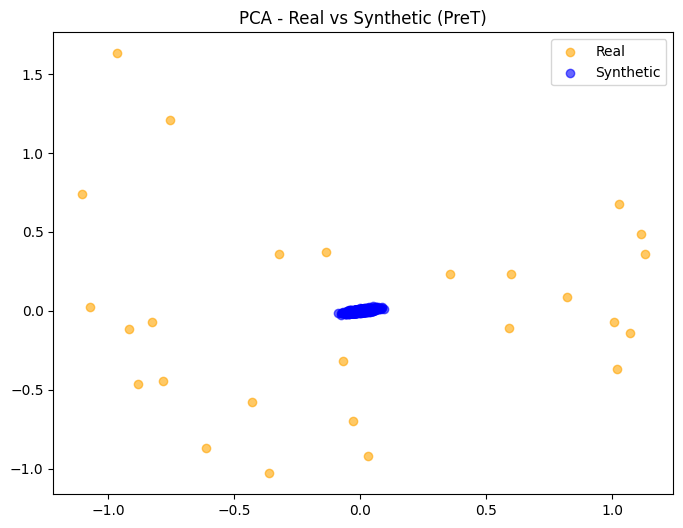

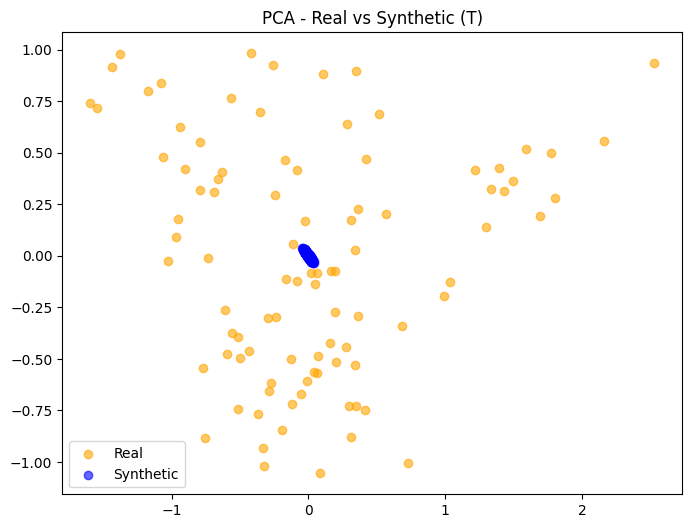

[Epoch 1751] β=1.00 | Recon: 0.0321 | KL: 0.0000 | Total: 0.0321
[Epoch 1752] β=1.00 | Recon: 0.0314 | KL: 0.0000 | Total: 0.0314
[Epoch 1753] β=1.00 | Recon: 0.0321 | KL: 0.0000 | Total: 0.0321
[Epoch 1754] β=1.00 | Recon: 0.0304 | KL: 0.0000 | Total: 0.0304
[Epoch 1755] β=1.00 | Recon: 0.0324 | KL: 0.0000 | Total: 0.0324
[Epoch 1756] β=1.00 | Recon: 0.0307 | KL: 0.0000 | Total: 0.0307
[Epoch 1757] β=1.00 | Recon: 0.0328 | KL: 0.0000 | Total: 0.0328
[Epoch 1758] β=1.00 | Recon: 0.0316 | KL: 0.0000 | Total: 0.0316
[Epoch 1759] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 1760] β=1.00 | Recon: 0.0300 | KL: 0.0000 | Total: 0.0300
[Epoch 1761] β=1.00 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 1762] β=1.00 | Recon: 0.0314 | KL: 0.0000 | Total: 0.0314
[Epoch 1763] β=1.00 | Recon: 0.0304 | KL: 0.0000 | Total: 0.0304
[Epoch 1764] β=1.00 | Recon: 0.0319 | KL: 0.0000 | Total: 0.0319
[Epoch 1765] β=1.00 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 1766] β=1.00 | Rec

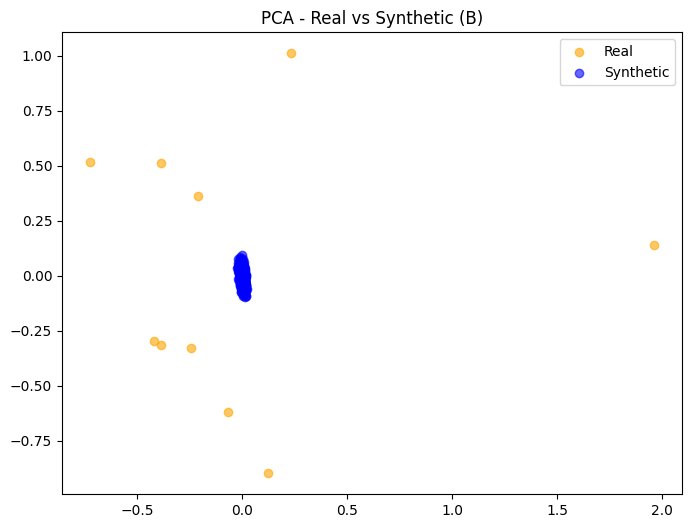

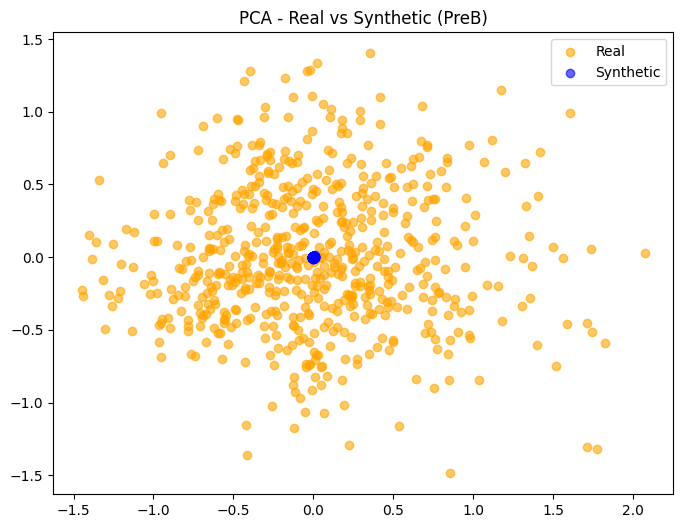

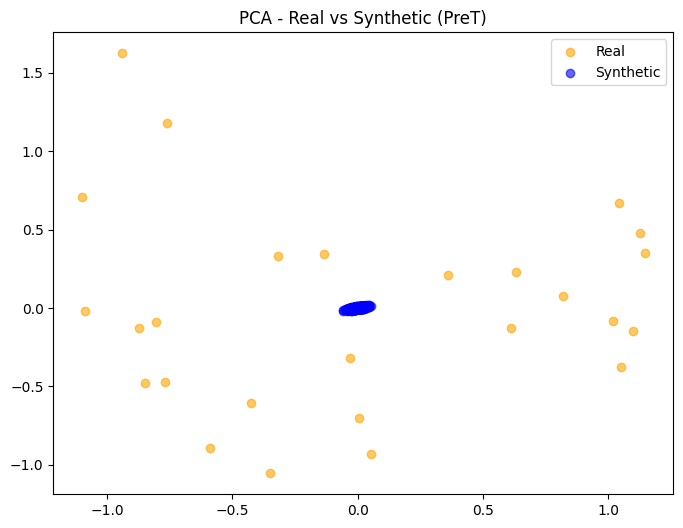

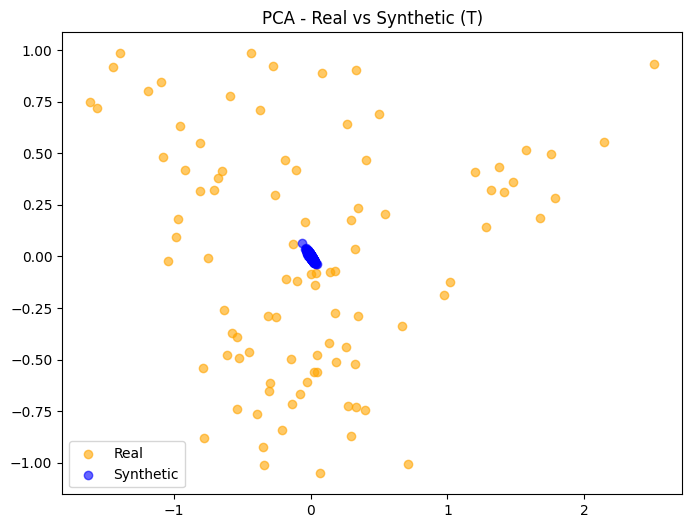

[Epoch 2001] β=1.00 | Recon: 0.0297 | KL: 0.0000 | Total: 0.0297
[Epoch 2002] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 2003] β=1.00 | Recon: 0.0295 | KL: 0.0000 | Total: 0.0295
[Epoch 2004] β=1.00 | Recon: 0.0327 | KL: 0.0000 | Total: 0.0327
[Epoch 2005] β=1.00 | Recon: 0.0309 | KL: 0.0000 | Total: 0.0309
[Epoch 2006] β=1.00 | Recon: 0.0312 | KL: 0.0000 | Total: 0.0312
[Epoch 2007] β=1.00 | Recon: 0.0313 | KL: 0.0000 | Total: 0.0313
[Epoch 2008] β=1.00 | Recon: 0.0296 | KL: 0.0000 | Total: 0.0296
[Epoch 2009] β=1.00 | Recon: 0.0299 | KL: 0.0000 | Total: 0.0299
[Epoch 2010] β=1.00 | Recon: 0.0322 | KL: 0.0000 | Total: 0.0322
[Epoch 2011] β=1.00 | Recon: 0.0297 | KL: 0.0000 | Total: 0.0297
[Epoch 2012] β=1.00 | Recon: 0.0306 | KL: 0.0000 | Total: 0.0306
[Epoch 2013] β=1.00 | Recon: 0.0308 | KL: 0.0000 | Total: 0.0308
[Epoch 2014] β=1.00 | Recon: 0.0302 | KL: 0.0000 | Total: 0.0302
[Epoch 2015] β=1.00 | Recon: 0.0307 | KL: 0.0000 | Total: 0.0307
[Epoch 2016] β=1.00 | Rec

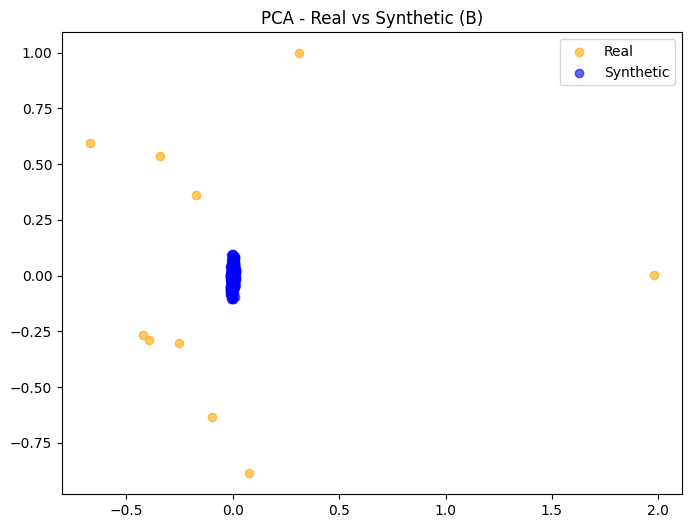

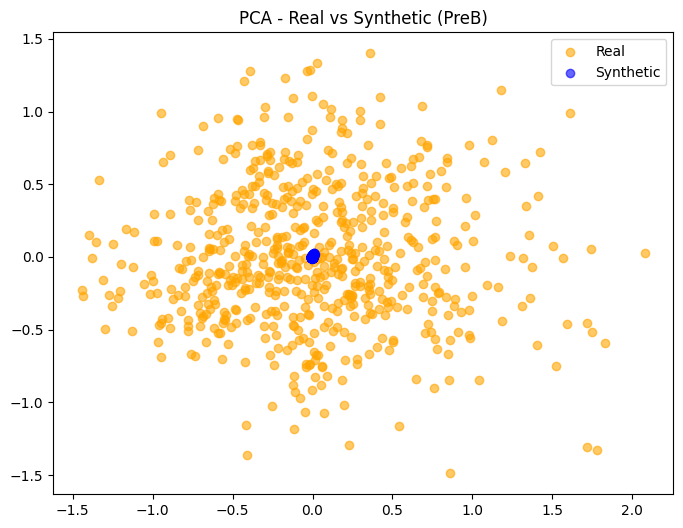

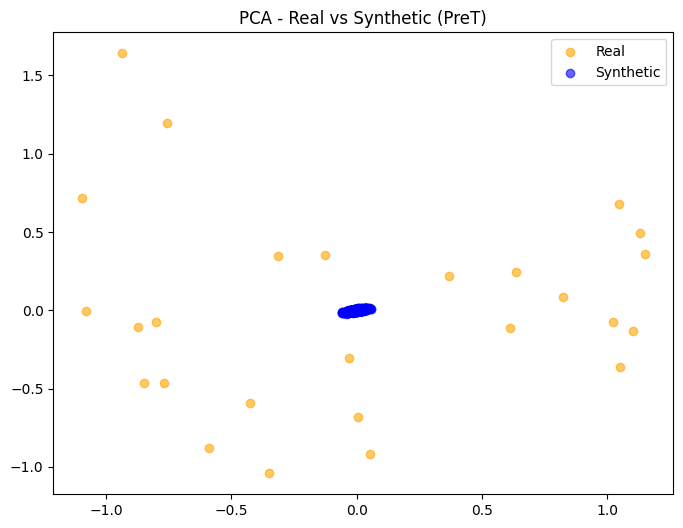

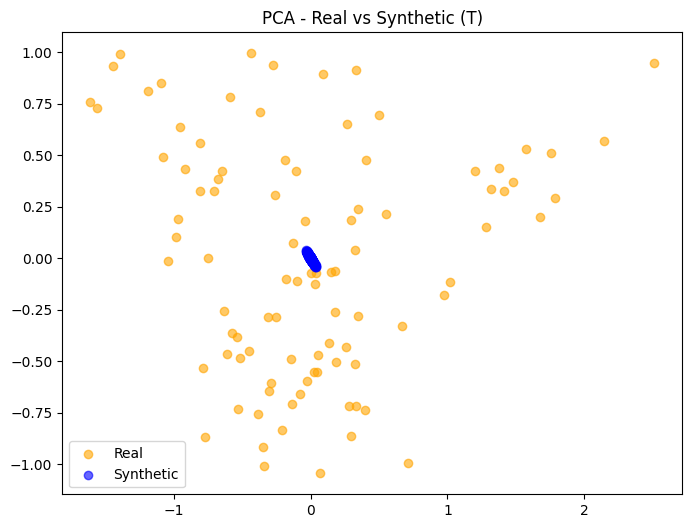

[Epoch 2251] β=1.00 | Recon: 0.0322 | KL: 0.0000 | Total: 0.0322
[Epoch 2252] β=1.00 | Recon: 0.0310 | KL: 0.0000 | Total: 0.0310
[Epoch 2253] β=1.00 | Recon: 0.0321 | KL: 0.0000 | Total: 0.0321
[Epoch 2254] β=1.00 | Recon: 0.0312 | KL: 0.0000 | Total: 0.0312
[Epoch 2255] β=1.00 | Recon: 0.0325 | KL: 0.0000 | Total: 0.0325
[Epoch 2256] β=1.00 | Recon: 0.0295 | KL: 0.0000 | Total: 0.0295
[Epoch 2257] β=1.00 | Recon: 0.0295 | KL: 0.0000 | Total: 0.0295
[Epoch 2258] β=1.00 | Recon: 0.0308 | KL: 0.0000 | Total: 0.0308
[Epoch 2259] β=1.00 | Recon: 0.0326 | KL: 0.0000 | Total: 0.0326
[Epoch 2260] β=1.00 | Recon: 0.0308 | KL: 0.0000 | Total: 0.0308
[Epoch 2261] β=1.00 | Recon: 0.0326 | KL: 0.0000 | Total: 0.0326
[Epoch 2262] β=1.00 | Recon: 0.0293 | KL: 0.0000 | Total: 0.0293
[Epoch 2263] β=1.00 | Recon: 0.0312 | KL: 0.0000 | Total: 0.0312
[Epoch 2264] β=1.00 | Recon: 0.0321 | KL: 0.0000 | Total: 0.0321
[Epoch 2265] β=1.00 | Recon: 0.0321 | KL: 0.0000 | Total: 0.0321
[Epoch 2266] β=1.00 | Rec

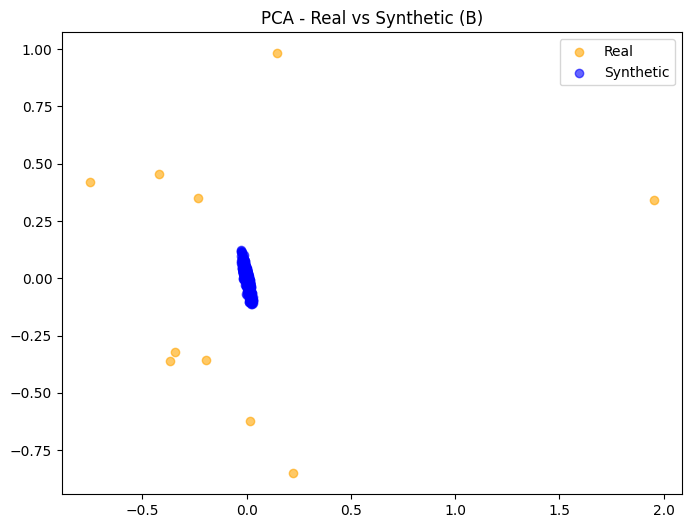

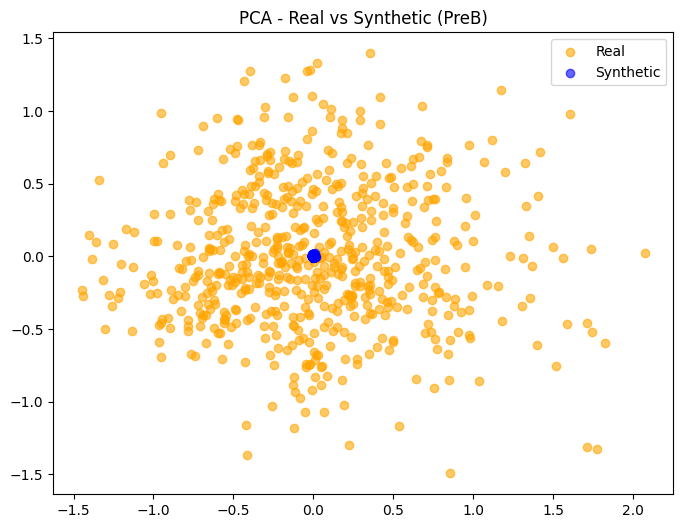

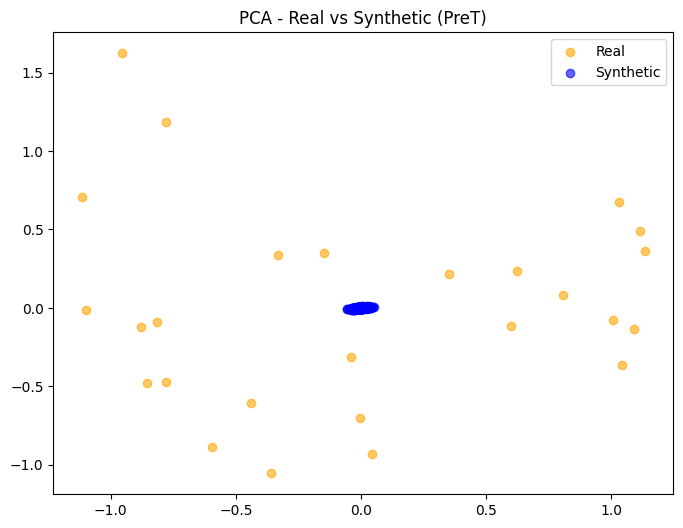

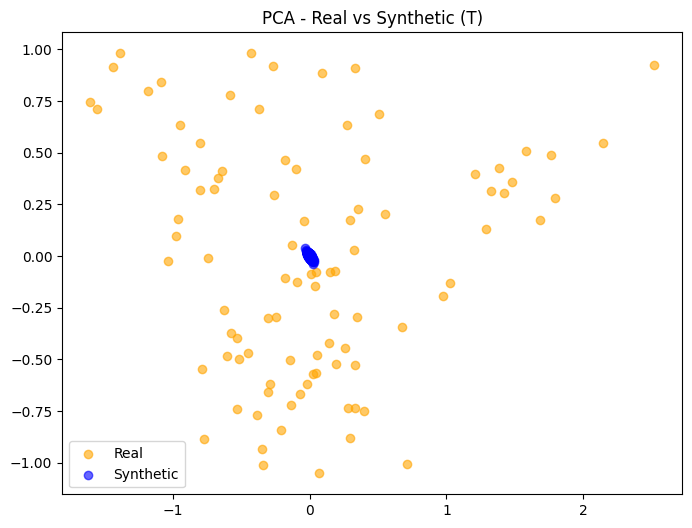

In [19]:
# Initialize model and optimizer
latent_dim = 32
cvae = CVAE(input_dim=X.shape[1], label_dim=n_classes, latent_dim=latent_dim, hidden_dim=256).to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=0.001)

# Train the model
train_cvae(cvae, dataloader, optimizer, epochs=2500, X_full=X, y_full=y, label_names=label_names, latent_dim=latent_dim, device=device)


### Data to see

['B', 'PreB', 'PreT', 'T']


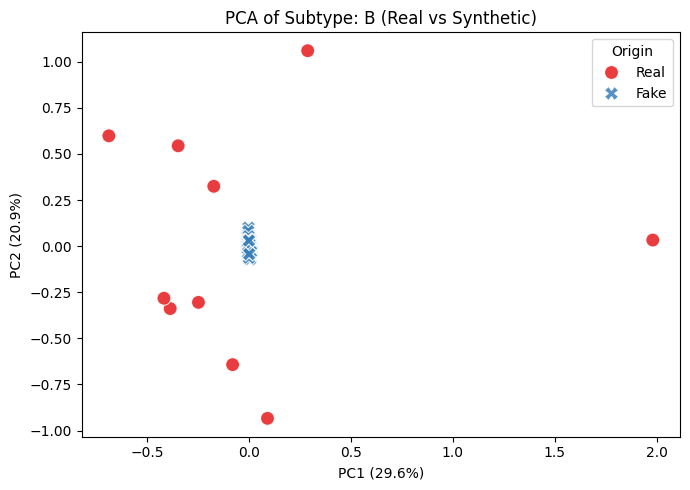

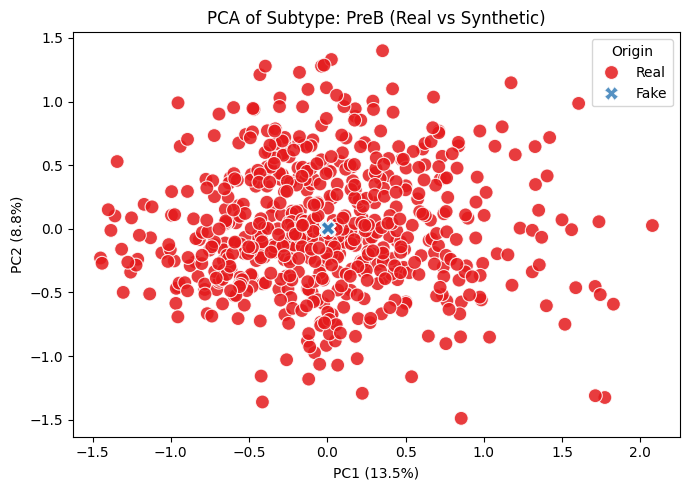

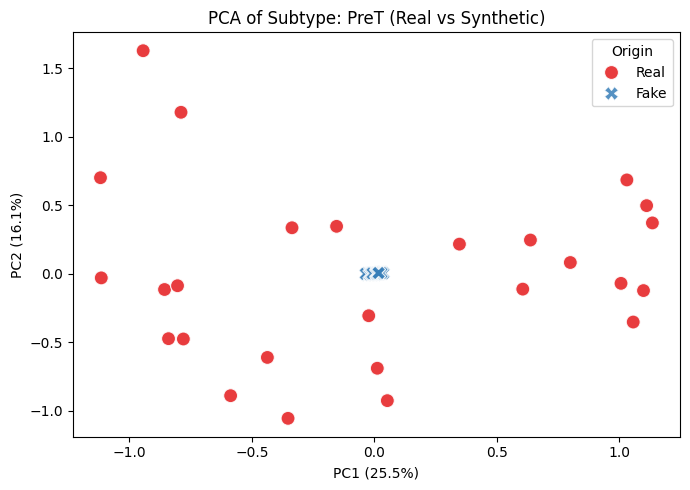

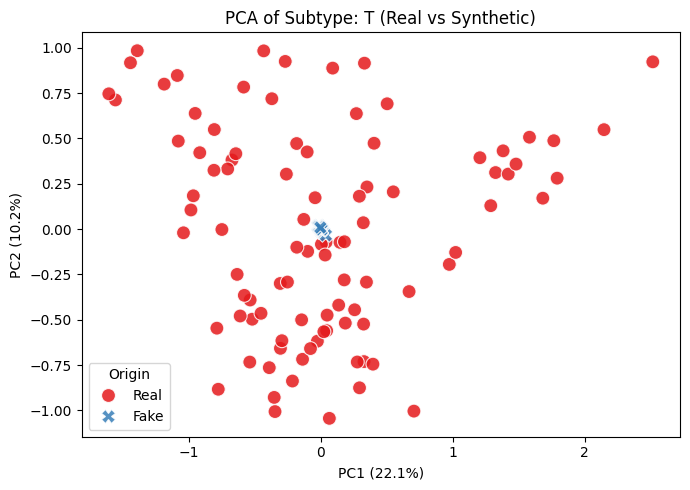

In [20]:
# Generate 5 synthetic samples for class_id 0
synthetic_df = generate_synthetic_df(
    model=cvae,
    class_id="all",
    n_samples=1000,
    label_names=label_names,
    feature_columns=feature_columns,
    latent_dim=latent_dim,
    device=device
)

# Show the DataFrame
synthetic_df.head()
a = synthetic_df['Cell_type'].unique()
print(sorted(a))

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# === Loop over all subtypes ===
for class_id, subtype_name in enumerate(label_names):
    # Generate synthetic samples for this class
    synthetic_df = generate_synthetic_df(
        model=cvae,
        class_id=class_id,
        n_samples=100,
        label_names=label_names,
        feature_columns=feature_columns,
        latent_dim=latent_dim,
        device=device
    )
    
    # Add metadata
    df_real = df[df['Cell_type'] == class_id].copy()
    df_real['Label'] = 'Real'
    synthetic_df['Label'] = 'Fake'
    synthetic_df['Cell_type'] = class_id  # Ensure label column exists

    # Combine
    combined = pd.concat([df_real, synthetic_df], ignore_index=True)

    # === PCA ===
    X = combined[feature_columns]
    y = combined['Label']

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Prepare plot DataFrame
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Label'] = combined['Label']

    # === Plot ===
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=pca_df,
        x='PC1', y='PC2',
        hue='Label', style='Label',
        palette='Set1',
        s=100, alpha=0.85
    )
    plt.title(f'PCA of Subtype: {subtype_name} (Real vs Synthetic)')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.legend(title='Origin')
    plt.tight_layout()
    plt.show()

